# 0. Preparation (Required to Execute)

## 0.1 Libraries

In [16]:
import  os
import shutil
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from efficientnet.tfkeras import EfficientNetB0 
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## 0.2 GPU Adjustment

In [2]:
#Check if there is a GPU Available
import tensorflow as tf
tf.config.list_physical_devices('GPU')

tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

# 1. Load Data

##  1.1 Create / Initialize Directory

In [8]:
original_dataset_path = 'CollectionOfDataVersion/6ClassLatest' #Dataset Path

#Specify the path for the new training, validation, and test directories
base_dir = 'Dataset' 
os.makedirs(base_dir, exist_ok = True)

train_dir = os.path.join(base_dir, 'training')
os.makedirs(train_dir, exist_ok = True)

validation_dir = os.path.join(base_dir, 'validation')
os.makedirs(validation_dir, exist_ok = True)

test_dir = os.path.join(base_dir, 'test')
os.makedirs(test_dir, exist_ok = True)

#List the categories / class in the dataset
categories = [category for category in os.listdir(original_dataset_path) 
              if not category.startswith('.')] #Exclude hidden files

## 1.2 Split Data

In [ ]:
#Specify the ratio for splitting
train_ratio = 0.60
validation_ratio = 0.30
test_ratio = 0.10

#Stores total number of images for training, validation, and testing
total_images = [0,0,0]

#Split image into training, validation, and test data
for category in categories:
    category_path = os.path.join(original_dataset_path, category)
    
    #Store images
    images = [image for image in os.listdir(category_path)
             if not image.startswith('.')] #Exclude hidden images
    
    #Split the images
    train_images, test_images = train_test_split(images, 
                                                 test_size=test_ratio, 
                                                 random_state=42)
    
    remaining_images = list(set(images) - set(test_images))
    
    train_images, validation_images = train_test_split(remaining_images,
                                                      test_size = validation_ratio / (train_ratio + validation_ratio),
                                                      random_state=42)
    
    #Count the images per category / class for each directory
    total_images[0] += len(train_images)
    total_images[1] += len(validation_images)
    total_images[2] += len(test_images)
    
    #Create subdirectories in the new training, validation, and test directories
    training_catergory_dir = os.path.join(train_dir, category)
    os.makedirs(training_catergory_dir, exist_ok=True)
    
    validation_catergory_dir = os.path.join(validation_dir, category)
    os.makedirs(validation_catergory_dir, exist_ok=True)
    
    test_catergory_dir = os.path.join(test_dir, category)
    os.makedirs(test_catergory_dir, exist_ok=True)
    
    #Copy training images and set it in the category
    for image_name in train_images:
        source_path = os.path.join(category_path, image_name)
        destination_path = os.path.join(training_catergory_dir, image_name)
        shutil.copyfile(source_path, destination_path)
        
    #Copy validation images and set it in the category
    for image_name in validation_images:
        source_path = os.path.join(category_path, image_name)
        destination_path = os.path.join(validation_catergory_dir, image_name)
        shutil.copyfile(source_path, destination_path)
        
    #Copy test images and set it in the category
    for image_name in test_images:
        source_path = os.path.join(category_path, image_name)
        destination_path = os.path.join(test_catergory_dir, image_name)
        shutil.copyfile(source_path, destination_path)
    
print("Categories: ", categories)
print("Data Splitting Done")
print("Trainining Data: ", total_images[0])     
print("Validation Data: ", total_images[1]) 
print("Test Data: ", total_images[2]) 

# 2 Data Augmentation and Preprocessing

## 2.1 Augmentation of Training Data (Only do this if dataset is new)

### If augmentation has already been done, please don't run this, it will augment the augmented images and will create more copies that will ruin your memory hehe

In [ ]:
for category in categories:
    training_category_path = os.path.join(train_dir, category)
    images = [image for image in os.listdir(training_category_path)
             if not image.startswith('.')] #Exclude hidden images
    
    train_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest',
    )
    
    for image_name in images:
        image_path = os.path.join(training_category_path, image_name)
        
        img = image.load_img(image_path, target_size=(256,256))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        
        i = 0;
        for batch in train_datagen.flow(x, 
                                        batch_size=1, 
                                        save_to_dir=training_category_path,
                                        save_prefix='aug', 
                                        save_format='jpeg'):
            i += 1
            if i >= 10: # Generate number of augments
               break

print("Augmentation Completed")

## 2.2 Preprocess Data

In [6]:
# Rescale data
rescale_data = ImageDataGenerator(rescale = 1./255)

# Data Generator for Training and Validation
train_generator = rescale_data.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=30,
    class_mode='categorical'
)

validation_generator = rescale_data.flow_from_directory(
    validation_dir,
    target_size=(256, 256),
    batch_size=20,
    class_mode='categorical'
)

Found 3926 images belonging to 6 classes.
Found 190 images belonging to 6 classes.


# 3. Model Building and Training

## 3.1 Build Model

In [9]:
#Use EfficientNet as a base model for transfer leraning
base_model = EfficientNetB0(weights='imagenet', 
                            include_top=False, 
                            input_shape=(256, 256, 3))

#Fine tune the pre-trained model
tune_at = 90 #Layers before this layer are frozen

# Freeze all layers before the fine-tune point
for layer in base_model.layers[:tune_at]:
    layer.trainable = False
    
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(),
    layers.Dropout(0.7),
    layers.Dense(len(categories), activation='softmax')
])

In [10]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [11]:
# Number of image per batch
len(train_generator)

131

## 3.2 Model Training

In [12]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
#Stops training if model does not improve in (5) Epoch
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=60,  # Experiment with the number of epochs
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[early_stopping]
)

print("Training has Finished!)

Epoch 1/60
131/131 [==============================] - 55s 353ms/step - loss: 5.8395 - accuracy: 0.5316 - val_loss: 5.0153 - val_accuracy: 0.7368
Epoch 2/60
131/131 [==============================] - 42s 319ms/step - loss: 4.5930 - accuracy: 0.8352 - val_loss: 4.5265 - val_accuracy: 0.8421
Epoch 3/60
131/131 [==============================] - 42s 321ms/step - loss: 4.2002 - accuracy: 0.9231 - val_loss: 4.2966 - val_accuracy: 0.8737
Epoch 4/60
131/131 [==============================] - 42s 322ms/step - loss: 3.9299 - accuracy: 0.9615 - val_loss: 4.1298 - val_accuracy: 0.8947
Epoch 5/60
131/131 [==============================] - 42s 322ms/step - loss: 3.7262 - accuracy: 0.9727 - val_loss: 3.9050 - val_accuracy: 0.9053
Epoch 6/60
131/131 [==============================] - 42s 322ms/step - loss: 3.5218 - accuracy: 0.9768 - val_loss: 3.6986 - val_accuracy: 0.9263
Epoch 7/60
131/131 [==============================] - 42s 323ms/step - loss: 3.3008 - accuracy: 0.9870 - val_loss: 3.5031 - val_ac

## 3.2 Save the Model

In [14]:
# Save the model
model.save('SavedModel.h5')
print("Model has been Saved")

# 4. Model's Performance Plot

In [19]:
model = load_model('SavedModel.h5')

test_loss, test_acc = model.evaluate(validation_generator, verbose=2)
print('\nTest accuracy:', test_acc)

10/10 - 4s - loss: 0.3812 - accuracy: 0.9368 - 4s/epoch - 357ms/step

Test accuracy: 0.9368420839309692


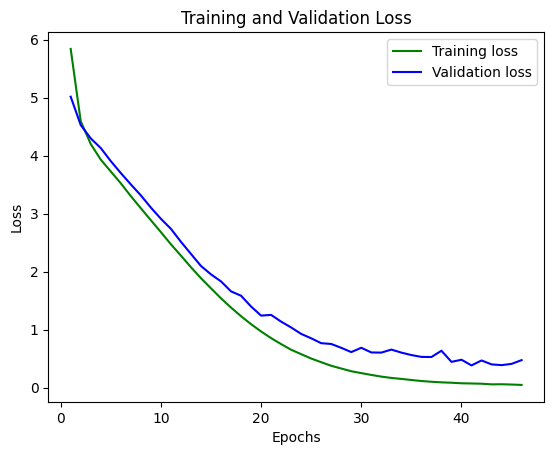

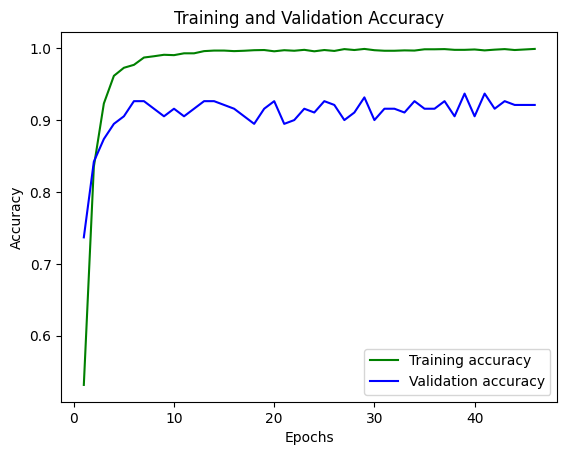

In [22]:
# Plot the training and validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, train_acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

Found 190 images belonging to 6 classes.
6/6 [==============================] - 2s 298ms/step


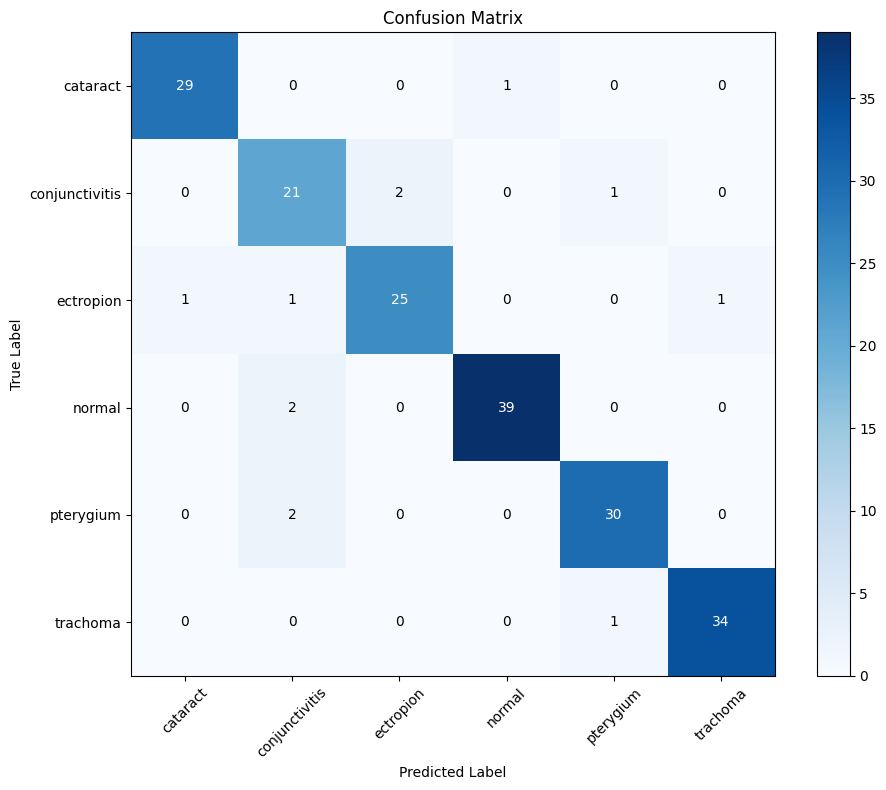

Accuracy: 0.9368421052631579


In [38]:
validation_dir = 'Dataset/validation'

# ImageDataGenerator for validation data
validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',  # Change if binary classification
    shuffle=False
)

# Generate predictions
predictions = model.predict(validation_generator)

# Get predicted and true classes
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes

# Create confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(validation_generator.class_indices))
plt.xticks(tick_marks, validation_generator.class_indices.keys(), rotation=45)
plt.yticks(tick_marks, validation_generator.class_indices.keys())

plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Display the values inside the matrix
for i in range(len(validation_generator.class_indices)):
    for j in range(len(validation_generator.class_indices)):
        plt.text(j, i, str(conf_matrix[i, j]), ha="center", va="center", color="white" if conf_matrix[i, j] > conf_matrix.max() / 2 else "black")

plt.tight_layout()
plt.show()

print("Accuracy:", accuracy)

In [45]:
# Assuming y_true is the true labels and y_pred is the predicted labels
y_true = validation_generator.classes
y_pred = model.predict(validation_generator)  # Replace 'model' with the actual model instance

# Convert predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Generate and print classification report
target_names = validation_generator.class_indices.keys()
print(classification_report(y_true, y_pred_labels, target_names=target_names))

# Calculate and print accuracy
accuracy = accuracy_score(y_true, y_pred_labels)
print('Accuracy:', accuracy)

6/6 [==============================] - 2s 295ms/step
                precision    recall  f1-score   support

      cataract       0.97      0.97      0.97        30
conjunctivitis       0.81      0.88      0.84        24
     ectropion       0.93      0.89      0.91        28
        normal       0.97      0.95      0.96        41
     pterygium       0.94      0.94      0.94        32
      trachoma       0.97      0.97      0.97        35

      accuracy                           0.94       190
     macro avg       0.93      0.93      0.93       190
  weighted avg       0.94      0.94      0.94       190

Accuracy: 0.9368421052631579


# 5. Test the Model

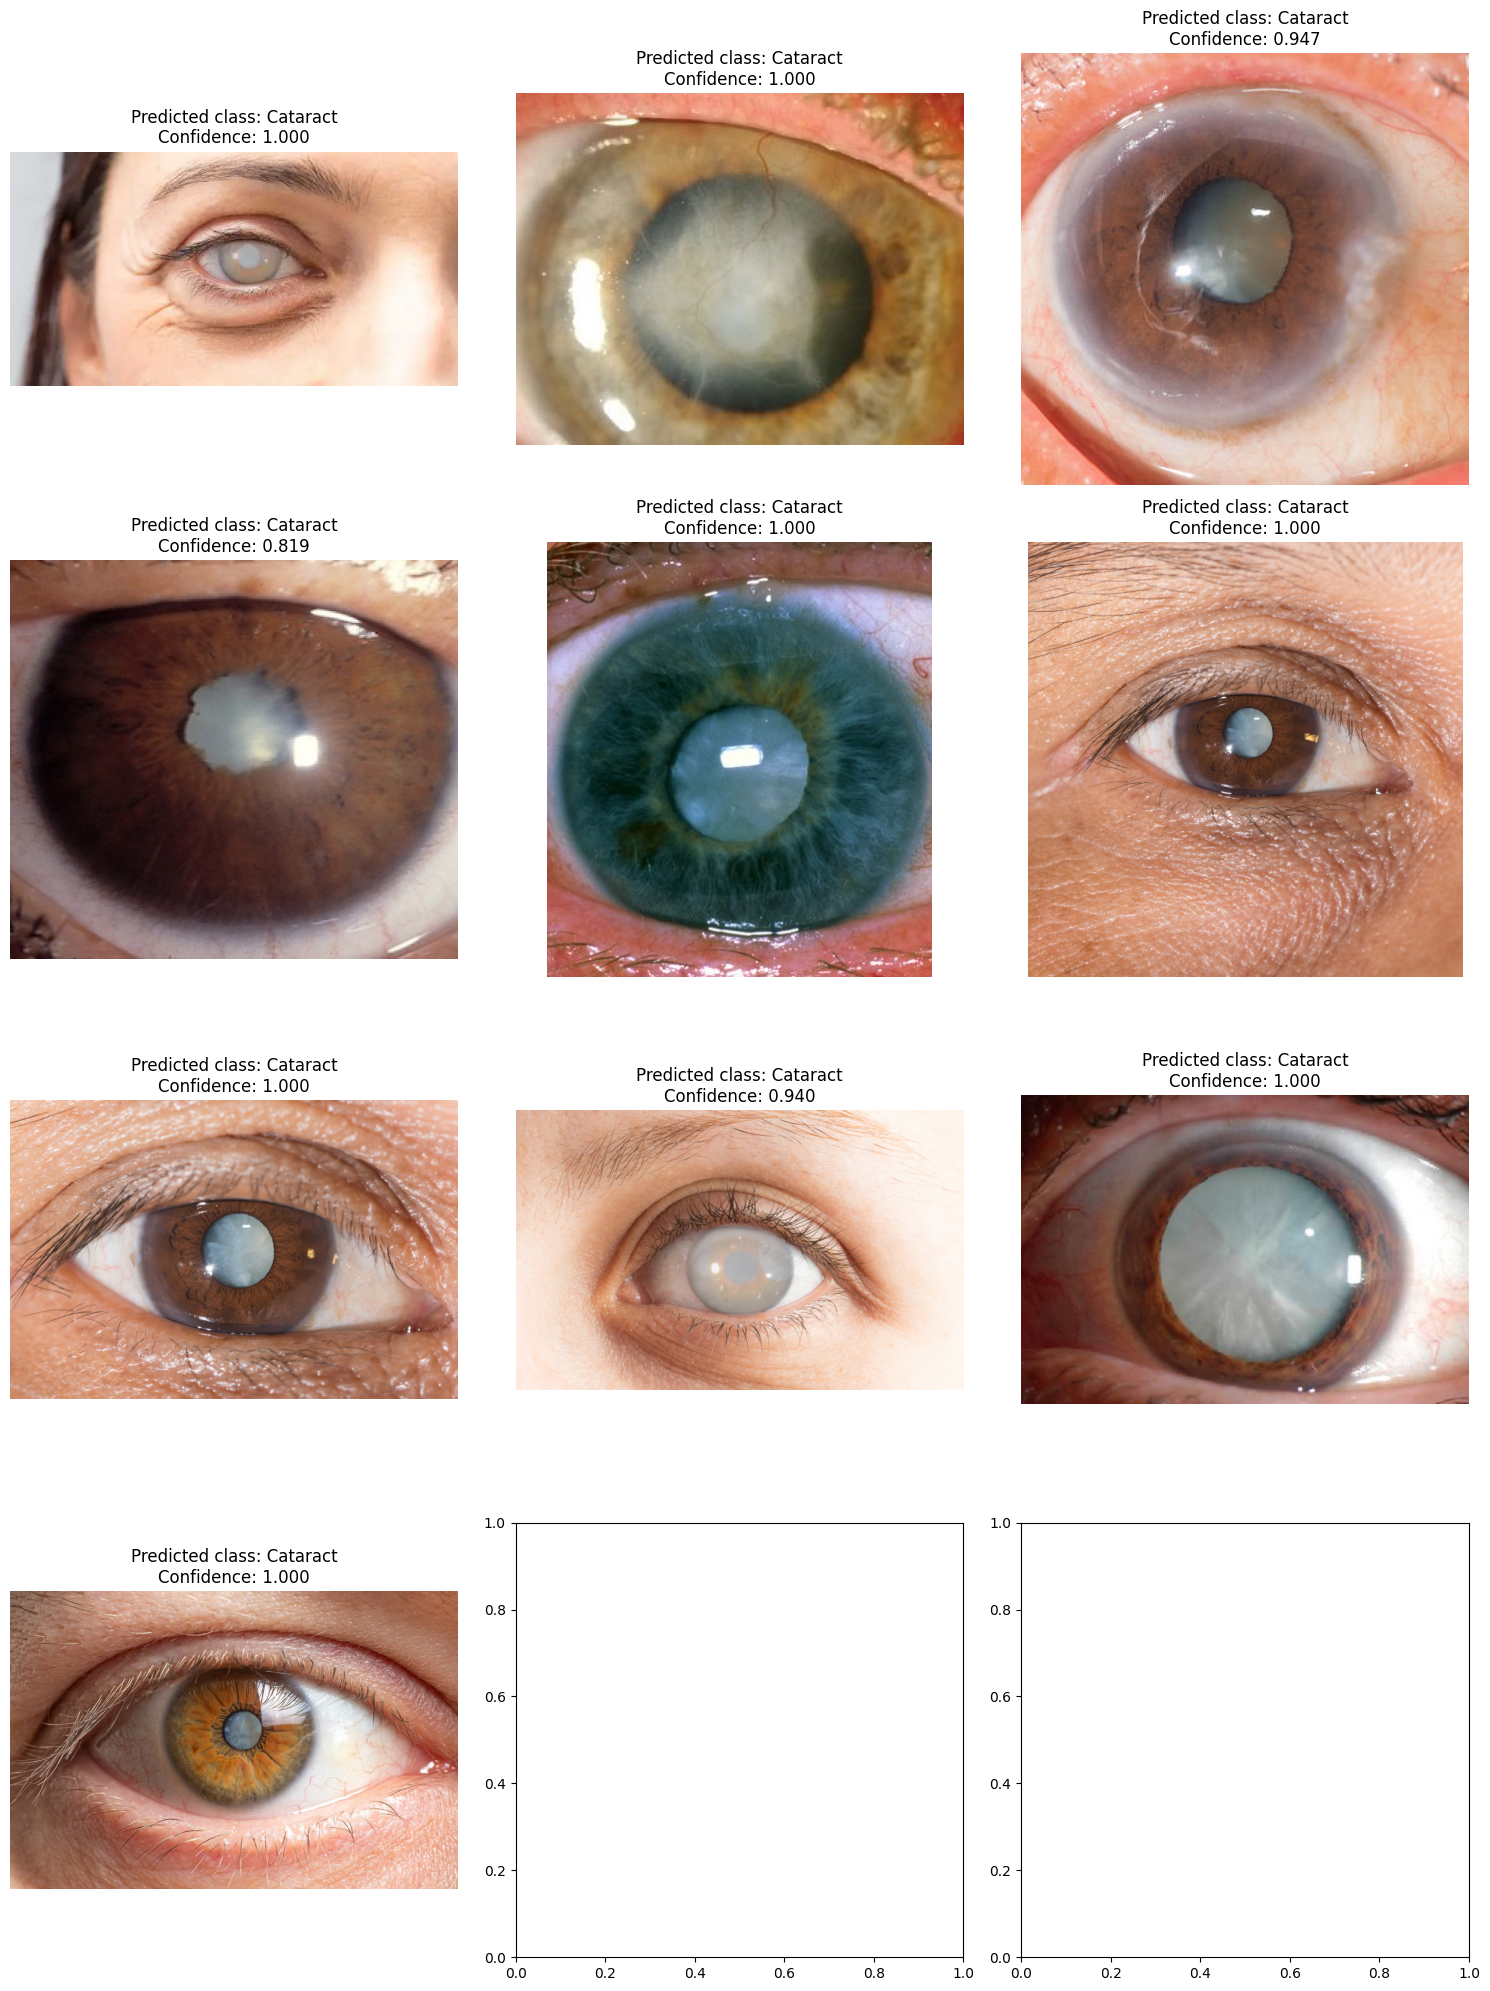

In [32]:
#Load the model
model = load_model('6ClassesLatest.h5')

#Directory of Test Data
test_path = 'Dataset/test/cataract'

#Eye Diseases Class
class_name = ["Cataract", "Conjunctivitis", "Ectropion", 
              "Normal", "Pterygium", "Trachoma"]

#Store Images name
images = [image for image in os.listdir(test_path)
         if not image.startswith('.')]

# Calculate the number of rows and columns
num_images = len(images)
num_cols = 3
num_rows = (num_images + num_cols - 1) // num_cols

# Set the size of the displayed image
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

for idx, image_name in enumerate(images):
    # Create path
    image_path = os.path.join(test_path, image_name)
    
    # Load and preprocess images
    img = image.load_img(image_path, target_size=(256, 256))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    
    # Make prediction
    predictions = model.predict(img_array, verbose=0)
    
    # Get the predicted class and confidence
    predicted_class = class_name[np.argmax(predictions)]
    confidence = predictions[0, np.argmax(predictions)]
    
    # Display the image with a specific size and formatted confidence
    row_idx = idx // num_cols
    col_idx = idx % num_cols
    axes[row_idx, col_idx].imshow(mpimg.imread(image_path))
    axes[row_idx, col_idx].set_title(f"Predicted class: {predicted_class}\nConfidence: {confidence:.3f}")
    axes[row_idx, col_idx].axis('off')  # Turn off axis labels

# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.show()